In [1]:
import numpy as np
import matplotlib.pyplot as plt

from satforecast.data import data

DEV_N_IMAGES = 50

data.download()
image_dir = data.process_gs_rainfall_daily()
image_files = data.get_files(image_dir, '*.npy')
dev_image_files = image_files[:DEV_N_IMAGES]

In [2]:
import torch
from torch import nn


class ConvRNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, kernal_size_, padding_, out_size=1):
        super().__init__()
        self.hidden_channels = hidden_channels
        self.conv1 = nn.Conv2d(in_channels + hidden_channels, hidden_channels, kernel_size=kernal_size_, padding=padding_)
        self.conv2 = nn.Conv2d(hidden_channels, hidden_channels, kernel_size=kernal_size_, padding=padding_)
        self.conv3 = nn.Conv2d(hidden_channels, in_channels, kernel_size=kernal_size_, padding=padding_)

    def forward(self, in_tensor, h):
        h = torch.cat((in_tensor, h), dim=1)
        h = torch.tanh(self.conv1(h))
        h = torch.tanh(self.conv2(h))
        return self.conv3(h), h

    def init_hidden(self, batch_size, image_size):
        return torch.zeros(batch_size, self.hidden_channels, *image_size)

In [3]:
def predict(model, X, seq_len):
    """ For a single batch """

    hidden = model.init_hidden(X.shape[0], X.shape[-2:])

    for step in range(seq_len - 1):
        _, hidden = model(X[:,step], hidden)

    pred, _ = model(X[:, -1], hidden)
    return pred

CPU times: user 32.4 s, sys: 27.6 s, total: 1min
Wall time: 31.7 s


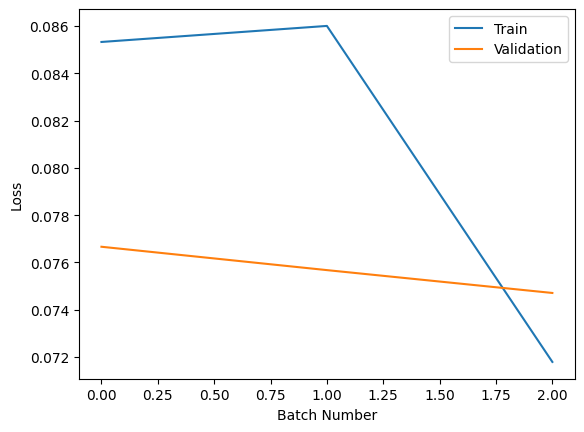

In [4]:
from math import ceil

from satforecast.modeling.model_selection import rolling_batch

def train(model, files_list, train_frac, val_frac, seq_len, batch_size):

    n_images = len(files_list)
    train_n = int(train_frac * n_images)
    images_per_batch = seq_len + batch_size
    n_batches = train_n / images_per_batch

    model.train()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters())
    train_losses = []
    
    if val_frac != 0:
        X_val, y_val = rolling_batch(
                                        files = files_list,
                                        start = train_n,
                                        stop = int((train_frac + val_frac)*n_images),
                                        seq_len = seq_len
                                        )
        val_losses = []

    for batch_n in range(int(n_batches)):
        
        # Use smaller final batch if needed
        # Use range(ceil(n_batches)) when correcting this
        # if batch_n == ceil(n_batches):
        #    batch_size = train_n - int(n_batches) * images_per_batch - seq_len
        #    print(batch_size) # needs to be passes (and used) in rolling_batch
        
        # Make training batch
        start_batch_ind = batch_n * images_per_batch
        stop_batch_ind = (batch_n + 1) * images_per_batch
        X_train, y_train = rolling_batch(
                                            files = files_list,
                                            start = start_batch_ind,
                                            stop = stop_batch_ind,
                                            seq_len = seq_len
                                            )

        # Predictions and loss on training batch
        y_pred = predict(model, X_train, seq_len)
        train_loss = criterion(y_pred, y_train)
        train_losses.append(train_loss.item())
        del X_train, y_train, y_pred

        # Update model
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        # Validation if not refitting
        if val_frac != 0:
            model.eval()
            y_pred = predict(model, X_val, seq_len)
            val_loss = criterion(y_pred, y_val)
            val_losses.append(val_loss.item())
            del y_pred, val_loss
            model.train()

    if val_frac == 0:
        return train_losses
    else:
        return train_losses, val_losses

# Test train function
crnn = ConvRNN(in_channels=1, hidden_channels=2, kernal_size_=3, padding_=1)
%time train_loss, val_loss = train(crnn, dev_image_files, 0.6, 0.2, 5, 5)
plt.plot(train_loss, label='Train')
plt.plot(val_loss, label='Validation')
plt.legend()
plt.xlabel('Batch Number')
plt.ylabel('Loss');

**Full training**

In [ ]:
crnn = ConvRNN(in_channels=1, hidden_channels=2, kernal_size_=3, padding_=1)
train_loss, val_loss = train(crnn, image_files, 0.6, 0.05, 5, 5)
plt.plot(train_loss, label='Train')
plt.plot(val_loss, label='Validation')
plt.legend()
plt.xlabel('Batch Number')
plt.ylabel('Loss');